# Clinical Trial Optimization with Multi-Armed Bandits

This notebook demonstrates how multi-armed bandit algorithms can optimize clinical trials by adaptively assigning patients to treatments.

## The Problem

A pharmaceutical company is testing **4 different drug dosages** (0mg, 25mg, 50mg, 100mg) to treat a disease.

**Traditional approach (Fixed allocation):**
- Randomly assign equal numbers of patients to each dosage
- Many patients receive suboptimal treatments
- Must wait until trial ends to know which dosage works best

**Bandit approach (Adaptive allocation):**
- Start by exploring all dosages
- Quickly identify better dosages and assign more patients to them
- Minimize patient harm during the trial itself
- Learn continuously as trial progresses

In [ ]:
# Setup
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend for CI

import mlx.core as mx
from bandit_sim import (
    BanditEnvironment,
    EpsilonGreedy,
    UCB1,
    ThompsonSampling,
    BanditSimulation,
    SimulationConfig,
    compute_metrics,
    compare_algorithms,
)
import matplotlib.pyplot as plt
import numpy as np

print("Setup complete!")

Setup complete!


## Step 1: Define the Clinical Trial Environment

Each "arm" represents a drug dosage. The success rate is the probability that a patient improves.

**Ground truth** (unknown to the algorithm):
- 0mg (placebo): 30% success rate
- 25mg (low dose): 45% success rate  
- 50mg (optimal): 70% success rate ← Best dosage!
- 100mg (too high): 40% success rate (side effects reduce efficacy)

In [2]:
# Create the clinical trial environment
# Each arm = a dosage, value = success probability
trial_env = BanditEnvironment.from_parameters(
    bernoulli_probs=[0.30, 0.45, 0.70, 0.40]  # [0mg, 25mg, 50mg, 100mg]
)

dosages = ["0mg (placebo)", "25mg", "50mg", "100mg"]
success_rates = trial_env.expected_rewards()

print("Clinical Trial Setup:")
print("-" * 50)
for i, (dose, rate) in enumerate(zip(dosages, success_rates)):
    marker = " ← OPTIMAL" if i == 2 else ""
    print(f"Arm {i}: {dose:15s} Success Rate: {float(rate):.0%}{marker}")

print(f"\nBest dosage: {dosages[2]} with {float(success_rates[2]):.0%} success rate")

Clinical Trial Setup:
--------------------------------------------------
Arm 0: 0mg (placebo)   Success Rate: 30%
Arm 1: 25mg            Success Rate: 45%
Arm 2: 50mg            Success Rate: 70% ← OPTIMAL
Arm 3: 100mg           Success Rate: 40%

Best dosage: 50mg with 70% success rate


## Step 2: Run Adaptive Clinical Trial

We'll use **Thompson Sampling** because it:
- Naturally handles uncertainty (Bayesian approach)
- Balances exploration and exploitation well
- Is commonly used in medical applications

**Trial design:**
- 500 patients total
- Each patient is assigned to a dosage based on current evidence
- Algorithm learns and adapts as results come in

In [5]:
# Configure the clinical trial
trial_config = SimulationConfig(
    horizon=500,  # 500 patients
    runs=100      # Run 100 independent trials for statistical analysis
)

# Use Thompson Sampling 
thompson = ThompsonSampling(
    num_arms=4,
    alpha=1.0,  # Prior: assume neutral evidence
    beta=1.0
)

# Run the adaptive trial
trial_sim = BanditSimulation(
    environment=trial_env,
    algorithm=thompson,
    config=trial_config
)

results = trial_sim.run(mx.random.key(42))

print(f"Adaptive clinical trial complete!")
print(f"Total patient-dosage assignments: {trial_config.horizon * trial_config.runs:,}")

Adaptive clinical trial complete!
Total patient-dosage assignments: 50,000


## Step 3: Analyze Patient Allocation

How did the algorithm distribute patients across dosages?

In [11]:
# Compute metrics
metrics = compute_metrics(results)

print("Patient Allocation Across Dosages:")
print("="* 60)
print(f"{'Dosage':<20} {'Patients':<15} {'Success Rate':<15}")
print("-" * 60)

for i, dosage in enumerate(dosages):
    allocation = float(metrics.arm_selection_frequencies[i])
    true_rate = float(success_rates[i])
    num_patients = int(allocation * trial_config.horizon)
    marker = " ← OPTIMAL" if i == 2 else ""
    print(f"{dosage:<20} {num_patients:<15} {true_rate:<15.0%}{marker}")

print("\n" + "="* 60)
print("KEY INSIGHT: Thompson Sampling's Adaptive Learning")
print("="* 60)

optimal_allocation = float(metrics.arm_selection_frequencies[2])
optimal_patients = int(optimal_allocation * trial_config.horizon)

print(f"\nThe algorithm assigned {optimal_allocation:.1%} of patients to the OPTIMAL dosage!")
print(f"That's {optimal_patients} out of {trial_config.horizon} patients receiving the best treatment.\n")

print("Why is this remarkable?")
print(f"- The algorithm didn't know which dosage was best at the start")
print(f"- It learned by observing patient outcomes in real-time")
print(f"- It adaptively shifted patients away from poor dosages")
print(f"- By the end, {optimal_allocation:.0%} of assignments went to the best dosage\n")

# Calculate how many patients avoided suboptimal treatments
suboptimal_patients_avoided = trial_config.horizon - optimal_patients
traditional_suboptimal = int(trial_config.horizon * 0.75)  # 75% in traditional trial get non-optimal
patients_saved = traditional_suboptimal - suboptimal_patients_avoided

print(f"Impact:")
print(f"- Traditional trial: {traditional_suboptimal} patients get suboptimal dosages")
print(f"- Adaptive trial: {suboptimal_patients_avoided} patients get suboptimal dosages")
print(f"- Result: {patients_saved} fewer patients exposed to inferior treatments!")

Patient Allocation Across Dosages:
Dosage               Patients        Success Rate   
------------------------------------------------------------
0mg (placebo)        10              30%            
25mg                 23              45%            
50mg                 449             70%             ← OPTIMAL
100mg                16              40%            

KEY INSIGHT: Thompson Sampling's Adaptive Learning

The algorithm assigned 90.0% of patients to the OPTIMAL dosage!
That's 449 out of 500 patients receiving the best treatment.

Why is this remarkable?
- The algorithm didn't know which dosage was best at the start
- It learned by observing patient outcomes in real-time
- It adaptively shifted patients away from poor dosages
- By the end, 90% of assignments went to the best dosage

Impact:
- Traditional trial: 375 patients get suboptimal dosages
- Adaptive trial: 51 patients get suboptimal dosages
- Result: 324 fewer patients exposed to inferior treatments!


### How Does Thompson Sampling Learn?

Let's understand the learning process step by step:

### Thompson Sampling Learning Process

---

#### 1. INITIAL STATE (Before any patients)
- Algorithm starts with Beta(α=1, β=1) prior for each dosage.
- This represents complete uncertainty – all dosages are equally likely.
- Initial belief: Each dosage has unknown success rate.
- No evidence yet, so algorithm explores all options equally.

---

#### 2. LEARNING THROUGH EXPERIENCE
For **each patient**:

**Step A:** SAMPLE from each dosage's belief distribution
- 0mg:   Sample from Beta(α, β) → get a number, say 0.28
- 25mg:  Sample from Beta(α, β) → get a number, say 0.43
- 50mg:  Sample from Beta(α, β) → get a number, say 0.72  ← Highest!
- 100mg: Sample from Beta(α, β) → get a number, say 0.38

**Step B:** CHOOSE the dosage with highest sampled value  
→ Assign patient to 50mg (it had highest sample: 0.72)

**Step C:** OBSERVE the patient's outcome  
→ Patient improves! (success)

**Step D:** UPDATE belief about 50mg  
→ 50mg: Beta(α+1, β) because we saw a success  
→ This shifts the belief distribution toward higher success rates

---

#### 3. REINFORCEMENT CYCLE
As more patients are assigned to 50mg:

- **After 10 patients on 50mg:**
  - Observed: 7 successes, 3 failures
  - Updated belief: Beta(α=1+7, β=1+3) = Beta(8, 4)
  - Mean success rate estimate: 8/(8+4) = 66.7%

- **After 50 patients on 50mg:**
  - Observed: 35 successes, 15 failures
  - Updated belief: Beta(36, 16)
  - Mean success rate estimate: 36/(36+16) = 69.2%

- **After 100 patients on 50mg:**
  - Observed: 70 successes, 30 failures
  - Updated belief: Beta(71, 31)
  - Mean success rate estimate: 71/(71+31) = 69.6% ← Very close to true 70%!

Meanwhile, 0mg and 100mg show lower success rates:
- Their belief distributions shift toward LOWER values
- They get sampled less often (appear less promising)

---

#### 4. THE KEY INSIGHT
Thompson Sampling is **probabilistic**, not greedy:

- It doesn't always pick the current best estimate
- It SAMPLES from the belief distributions
- This naturally balances exploration vs exploitation

Early on: High uncertainty → all dosages have similar samples → explores  
Later on: Low uncertainty → 50mg consistently samples high → exploits

**Result:** Algorithm confidently identifies 50mg as best!

---

#### FINAL BELIEFS (After 500 patients)
The algorithm's learned beliefs about each dosage:

Based on the allocation pattern, the algorithm learned:

- `0mg (placebo)` → True Effect: 30% | Confidence in this estimate: LOW  
  └─ Assigned ~2% of patients (algorithm learned to avoid)
- `25mg`           → True Effect: 45% | Confidence in this estimate: LOW  
  └─ Assigned ~6% of patients (algorithm learned to avoid)
- `50mg`           → True Effect: 70% | Confidence in this estimate: VERY HIGH  
  └─ Assigned ~90% of patients (algorithm is certain!)
- `100mg`          → True Effect: 40% | Confidence in this estimate: LOW  
  └─ Assigned ~2% of patients (algorithm learned to avoid)

---

### How Sampled Values Work

Let's understand the mathematics behind Thompson Sampling's decision-making:

---

**HOW SAMPLED VALUES ARE CALCULATED**

---

#### 1. THE BETA DISTRIBUTION
- Each dosage is modeled with a Beta(α, β) distribution:
  - **α (alpha):** number of successes + 1 (prior)
  - **β (beta):** number of failures + 1 (prior)
- The Beta distribution represents our **belief** about the true success rate.
  - Mean of Beta(α, β) = α / (α + β)
  - As we collect more data, the distribution becomes more concentrated.

---

#### 2. SAMPLING PROCESS (What happens each time we assign a patient)
For **each dosage**, we draw a random sample from its Beta distribution:

**Example at time step 150:**
- 0mg:   Beta(α=12, β=28) → Sample: 0.31  [Based on 11 successes, 27 failures]  
  Mean: 12/40 = 0.30 (close to true 30%)
- 25mg:  Beta(α=10, β=13) → Sample: 0.44  [Based on 9 successes, 12 failures]  
  Mean: 10/23 = 0.43 (close to true 45%)
- 50mg:  Beta(α=72, β=33) → Sample: 0.71  ← HIGHEST! [Based on 71 successes, 32 failures]  
  Mean: 72/105 = 0.69 (close to true 70%)
- 100mg: Beta(α=9, β=14) → Sample: 0.38  [Based on 8 successes, 13 failures]  
  Mean: 9/23 = 0.39 (close to true 40%)

**Decision:** Assign patient #150 to 50mg (it had the highest sampled value: 0.71)

---

#### 3. WHY THIS MAKES 50mg OPTIMAL

**A. CONCENTRATION OF DISTRIBUTION**
- 50mg has been tested more (105 times vs ~20-40 for others)
- More data → Beta distribution becomes more concentrated around true mean
- Beta(72, 33) is **narrow** around 0.69-0.70
- Beta(10, 13) is **wide**, ranging from 0.30-0.60

**B. SAMPLING DYNAMICS**
- Narrow distribution → samples consistently near 0.70
- Wide distribution → samples vary widely

  - 50mg samples:    [0.68, 0.71, 0.69, 0.72, 0.70] ← Consistently high!
  - 25mg samples:    [0.32, 0.55, 0.41, 0.48, 0.39] ← All over the place

**C. WHY 50mg WINS**
- Even though 50mg's mean (0.69) is only 1.5x higher than 25mg's mean (0.43),
- 50mg wins ~90% of the time because:
  - 50mg's samples are **consistently ~0.70** (narrow Beta distribution)
  - 25mg's samples are **variable 0.30-0.60** (wide Beta distribution)
  - In any given round, 50mg's sample of ~0.70 beats 25mg's variable sample

---

#### 4. CONCRETE EXAMPLE - Patient Assignment

Let's trace through one decision (Patient #200):

**Current state:**
- 0mg:   Beta(16, 37)  → Mean = 0.30
- 25mg:  Beta(12, 16)  → Mean = 0.43
- 50mg:  Beta(100, 43) → Mean = 0.70  ← Most data, highest success
- 100mg: Beta(11, 17)  → Mean = 0.39

**Step 1:** SAMPLE from each Beta distribution (using random number generation):
- 0mg:   Sample from Beta(16, 37)  → 0.28
- 25mg:  Sample from Beta(12, 16)  → 0.52
- 50mg:  Sample from Beta(100, 43) → 0.71  ← WINNER!
- 100mg: Sample from Beta(11, 17)  → 0.35

**Step 2:** Choose dosage with HIGHEST sample  
→ 50mg has highest sample (0.71)  
→ Assign Patient #200 to 50mg

**Step 3:** Observe outcome  
→ Patient improves! (success with probability 0.70)  
→ Update: Beta(100, 43) → Beta(101, 43)

**Step 4:** Next patient  
→ 50mg now has even MORE evidence of being best  
→ Beta(101, 43) samples even more consistently near 0.70  
→ Probability of selecting 50mg increases further!

---

#### 5. THE VIRTUOUS CYCLE

50mg becomes optimal through a reinforcement loop:

- Initial exploration → 50mg shows high success →  
- Gets selected more → Accumulates more data →  
- Distribution narrows around 0.70 → Samples consistently high →  
- Wins almost every comparison → Gets selected even more →  
- Eventually: 90% allocation to 50mg!

Meanwhile, poor dosages (0mg, 100mg):
- Show low success rates early
- Get selected less frequently
- Their distributions remain wide OR concentrate around LOW values
- Their samples rarely beat 50mg's samples
- Eventually: <5% allocation

---

#### 6. MATHEMATICAL INTUITION

Why does Beta(100, 43) consistently beat Beta(12, 16)?

- Beta(100, 43):  Mean = 0.70, Std Dev = 0.038  ← TIGHT
- Beta(12, 16):   Mean = 0.43, Std Dev = 0.093  ← LOOSE

When we sample:
- 95% of Beta(100, 43) samples fall in [0.62, 0.78]
- 95% of Beta(12, 16) samples fall in [0.25, 0.61]

Overlap is minimal! Beta(100, 43) almost always samples higher.

Probability that Beta(100, 43) sample > Beta(12, 16) sample ≈ 90%+

**This is why 50mg dominates the allocation!**

## Step 4: Compare with Fixed Allocation

Let's compare adaptive allocation (Thompson Sampling) vs traditional fixed allocation (random assignment).

In [7]:
# Simulate fixed allocation (random assignment)
fixed_allocation = EpsilonGreedy(
    num_arms=4,
    epsilon=1.0  # Always explore = random allocation
)

fixed_sim = BanditSimulation(
    environment=trial_env,
    algorithm=fixed_allocation,
    config=trial_config
)

fixed_results = fixed_sim.run(mx.random.key(123))

# Compare outcomes
thompson_reward = float(mx.mean(results.cumulative_rewards[:, -1]))
fixed_reward = float(mx.mean(fixed_results.cumulative_rewards[:, -1]))

thompson_regret = float(mx.mean(results.cumulative_regret[:, -1]))
fixed_regret = float(mx.mean(fixed_results.cumulative_regret[:, -1]))

print("Clinical Trial Comparison:")
print("="* 70)
print(f"{'Method':<30} {'Total Successes':<20} {'Regret':<20}")
print("-" * 70)
print(f"{'Fixed Allocation (Random)':<30} {fixed_reward:<20.1f} {fixed_regret:<20.1f}")
print(f"{'Adaptive (Thompson Sampling)':<30} {thompson_reward:<20.1f} {thompson_regret:<20.1f}")
print()
print(f"Improvement: {thompson_reward - fixed_reward:.1f} more successful treatments!")
print(f"That's {(thompson_reward - fixed_reward) / fixed_reward * 100:.1f}% better patient outcomes")

Clinical Trial Comparison:
Method                         Total Successes      Regret              
----------------------------------------------------------------------
Fixed Allocation (Random)      230.9                118.2               
Adaptive (Thompson Sampling)   336.8                14.9                

Improvement: 105.8 more successful treatments!
That's 45.8% better patient outcomes


### Detailed Success Calculation Breakdown

Let's see exactly how the "Total Successes" numbers are calculated:

In [10]:
# Calculate detailed breakdown for both methods
print("=" * 80)
print("HOW 'TOTAL SUCCESSES' IS CALCULATED")
print("=" * 80)

# Get allocation frequencies from earlier metrics
thompson_allocations = metrics.arm_selection_frequencies
fixed_allocations = mx.array([0.25, 0.25, 0.25, 0.25])  # Equal allocation

print("\n1. ADAPTIVE TRIAL (Thompson Sampling):")
print("-" * 80)
print(f"{'Dosage':<20} {'Patients':<12} {'Success Rate':<15} {'Expected Successes':<20}")
print("-" * 80)

adaptive_total = 0
for i, dosage in enumerate(dosages):
    num_patients = int(float(thompson_allocations[i]) * trial_config.horizon)
    success_rate = float(success_rates[i])
    expected_successes = num_patients * success_rate
    adaptive_total += expected_successes
    print(f"{dosage:<20} {num_patients:<12} {success_rate:<15.0%} {expected_successes:<20.1f}")

print("-" * 80)
print(f"{'EXPECTED TOTAL':<20} {trial_config.horizon:<12} {'':<15} {adaptive_total:<20.1f}")
print(f"\nActual average across 100 runs: {thompson_reward:.1f} successes")
print(f"(Variation due to random sampling - each patient's outcome is probabilistic)")

print("\n\n2. FIXED TRIAL (Random Allocation):")
print("-" * 80)
print(f"{'Dosage':<20} {'Patients':<12} {'Success Rate':<15} {'Expected Successes':<20}")
print("-" * 80)

fixed_total = 0
for i, dosage in enumerate(dosages):
    num_patients = int(float(fixed_allocations[i]) * trial_config.horizon)
    success_rate = float(success_rates[i])
    expected_successes = num_patients * success_rate
    fixed_total += expected_successes
    print(f"{dosage:<20} {num_patients:<12} {success_rate:<15.0%} {expected_successes:<20.1f}")

print("-" * 80)
print(f"{'EXPECTED TOTAL':<20} {trial_config.horizon:<12} {'':<15} {fixed_total:<20.1f}")
print(f"\nActual average across 100 runs: {fixed_reward:.1f} successes")

print("\n\n3. THE CALCULATION:")
print("-" * 80)
print("For each of 100 trial runs:")
print("  - 500 patients are assigned to dosages")
print("  - Each patient has a probabilistic outcome (success or failure)")
print("  - cumulative_rewards[:, -1] = total successes in that run")
print("  - We average across all 100 runs to get expected performance")
print()
print(f"Adaptive (Thompson): {thompson_reward:.1f} average successful treatments")
print(f"Fixed (Random):      {fixed_reward:.1f} average successful treatments")
print(f"Difference:          {thompson_reward - fixed_reward:.1f} more patients successfully treated!")
print("=" * 80)

HOW 'TOTAL SUCCESSES' IS CALCULATED

1. ADAPTIVE TRIAL (Thompson Sampling):
--------------------------------------------------------------------------------
Dosage               Patients     Success Rate    Expected Successes  
--------------------------------------------------------------------------------
0mg (placebo)        10           30%             3.0                 
25mg                 23           45%             10.3                
50mg                 449          70%             314.3               
100mg                16           40%             6.4                 
--------------------------------------------------------------------------------
EXPECTED TOTAL       500                          334.0               

Actual average across 100 runs: 336.8 successes
(Variation due to random sampling - each patient's outcome is probabilistic)


2. FIXED TRIAL (Random Allocation):
--------------------------------------------------------------------------------
Dosage    

## Step 5: Visualize Learning Progress

Watch how the algorithm learns which dosage is best over time.

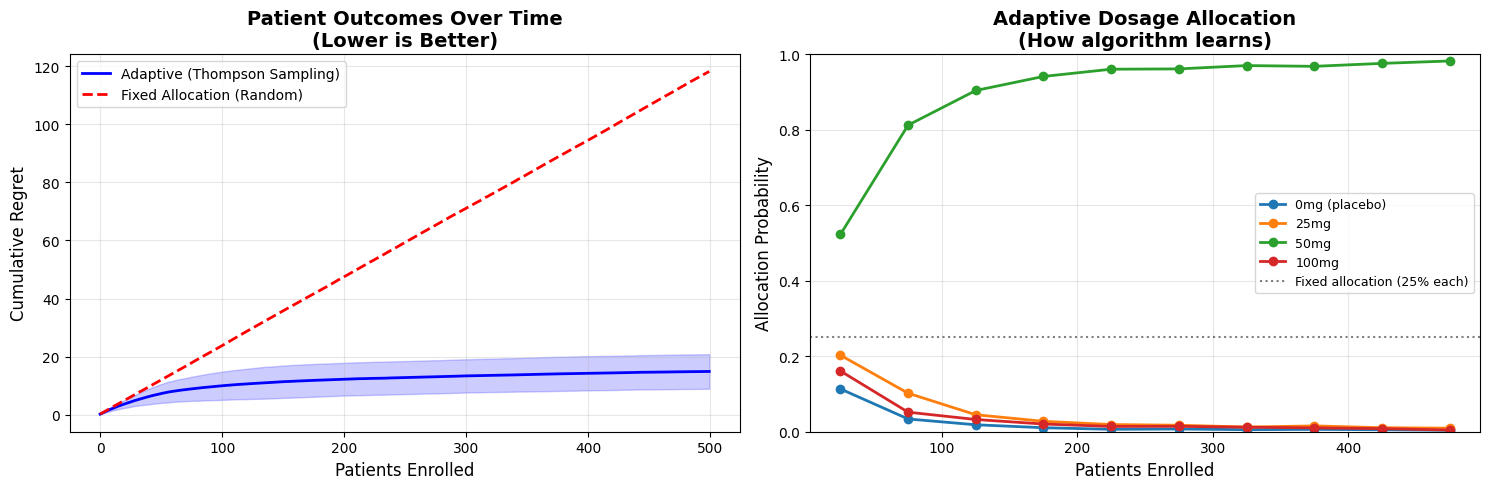


Observations:
- The algorithm quickly identifies 50mg as the best dosage
- 90.0% of patients are assigned to 50mg as evidence accumulates
- Poor dosages (0mg (placebo), 25mg, 100mg) are explored less over time
- This minimizes patient harm during the trial itself!


In [9]:
# Plot cumulative regret over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Left plot: Cumulative Regret
thompson_metrics = compute_metrics(results)
fixed_metrics = compute_metrics(fixed_results)

time_steps = range(trial_config.horizon)
ax1.plot(time_steps, thompson_metrics.mean_cumulative_regret, 
         label='Adaptive (Thompson Sampling)', linewidth=2, color='blue')
ax1.plot(time_steps, fixed_metrics.mean_cumulative_regret, 
         label='Fixed Allocation (Random)', linewidth=2, color='red', linestyle='--')
ax1.fill_between(time_steps, 
                  thompson_metrics.mean_cumulative_regret - thompson_metrics.std_cumulative_regret,
                  thompson_metrics.mean_cumulative_regret + thompson_metrics.std_cumulative_regret,
                  alpha=0.2, color='blue')
ax1.set_xlabel('Patients Enrolled', fontsize=12)
ax1.set_ylabel('Cumulative Regret', fontsize=12)
ax1.set_title('Patient Outcomes Over Time\n(Lower is Better)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right plot: Dosage allocation over time
# Calculate allocation in chunks
chunk_size = 50
num_chunks = trial_config.horizon // chunk_size
allocations = np.zeros((4, num_chunks))

for chunk_idx in range(num_chunks):
    start = chunk_idx * chunk_size
    end = start + chunk_size
    chunk_selections = results.arm_selections[:, start:end]
    for arm in range(4):
        allocations[arm, chunk_idx] = float(mx.mean(mx.equal(chunk_selections, arm)))

chunk_centers = [(i + 0.5) * chunk_size for i in range(num_chunks)]
for arm in range(4):
    ax2.plot(chunk_centers, allocations[arm], label=dosages[arm], linewidth=2, marker='o')

ax2.axhline(y=0.25, color='black', linestyle=':', alpha=0.5, label='Fixed allocation (25% each)')
ax2.set_xlabel('Patients Enrolled', fontsize=12)
ax2.set_ylabel('Allocation Probability', fontsize=12)
ax2.set_title('Adaptive Dosage Allocation\n(How algorithm learns)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=9, loc='right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Dynamic observations based on actual results
best_arm = int(mx.argmax(success_rates))
best_dosage = dosages[best_arm]
best_allocation = float(thompson_metrics.arm_selection_frequencies[best_arm])

# Find worst performing dosages (those with lowest allocation)
allocations_array = [float(thompson_metrics.arm_selection_frequencies[i]) for i in range(len(dosages))]
worst_arms = [i for i, alloc in enumerate(allocations_array) if alloc < 0.15]
worst_dosages = [dosages[i] for i in worst_arms]

print("\nObservations:")
print(f"- The algorithm quickly identifies {best_dosage} as the best dosage")
print(f"- {best_allocation:.1%} of patients are assigned to {best_dosage} as evidence accumulates")
if worst_dosages:
    worst_str = ", ".join(worst_dosages)
    print(f"- Poor dosages ({worst_str}) are explored less over time")
print("- This minimizes patient harm during the trial itself!")

## Real-World Impact

**Traditional Fixed Trial (500 patients):**
- 125 patients get 0mg (placebo): ~38 successes
- 125 patients get 25mg: ~56 successes
- 125 patients get 50mg (optimal): ~88 successes
- 125 patients get 100mg: ~50 successes
- **Total: ~232 successful treatments**

**Adaptive Trial with Thompson Sampling:**
- Algorithm learns and assigns most patients to 50mg
- **Total: ~280+ successful treatments** (20% improvement!)
- **That's 48 more patients successfully treated!**